 Technical Interview for Glovo
=====

### This notebook is structured as follows :

        0) Import of libraries and modules
   ### 1) Task 1: Exploratory Analysis and Data Munging
       1a) Data preparation: data importing, creation of dummy variables, pivoting, and joining of dataframes
       1b) Exploratory plots and report: histograms for the variables, correlation matrix, study and handling of     
       collinearity, and a dashboard made with a seaborn pairplot.
   ### 2) Task 2 and 3: Create a Predictive Algorithm and Evaluate it
       2a) First model and evaluation with sklearn: discussion of evaluation metrics
       2b) Cross validation with k-folds and grid search: grid search for the regularization strength 'C'
       2c) Comparison with random forest, does interaction add much?
       2d) Summary of the predictive model

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
print('matplotlib: {}'.format( matplotlib.__version__))
from pandas.tools.plotting import scatter_matrix
from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from math import sqrt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
from IPython.display import clear_output
params = {'xtick.direction': 'in','xtick.major.size': 8,'xtick.minor.size': 5,'xtick.color': '0.1',
          'ytick.direction': 'in','ytick.major.size': 8,'ytick.minor.size': 5,'ytick.color': '0.15',
          'axes.linewidth': 2.0,'axes.edgecolor': '0.1','grid.color': '.9',"font.size":8}
sns.set_style('white', params)
% matplotlib inline

matplotlib: 2.0.1


C:\Users\Koray\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


ModuleNotFoundError: No module named 'statsmodels'

## Task 1: Exploratory Analysis and Data Munging

### Data preparation

First is first, we load both files and see how the data looks like.

In [344]:
dflife = pd.read_csv('Courier_lifetime_data.csv')
dfweek = pd.read_csv('Courier_weekly_data.csv')

In [345]:
dflife.head()

,courier,feature_1,feature_2
0,208,a,25.0
1,218,c,0.0
2,225,c,NaN
3,231,c,0.0
4,242,c,NaN


In [346]:
dfweek.head()

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17
0,3767,2,6,34,38,0.0789,0.9211,140.4737,0.1316,2162.4737,0.7632,7.340776,8,20.208158,5.236316,0.8158,43.384804,1,19
1,3767,4,-1,42,37,0.0000,1.0000,135.5946,0.0811,2097.4054,0.9459,11.883784,19,18.855405,5.689459,0.8919,35.078042,3,11
2,3767,5,24,41,43,0.0233,0.9767,131.0930,0.0233,2043.8837,0.9302,7.072100,16,18.925116,5.138605,0.9302,31.455285,1,10
3,3767,6,-22,65,66,0.0606,0.9394,120.1515,0.0000,2124.2727,0.7727,7.356567,33,18.259697,4.704394,0.7879,34.252991,1,30
4,6282,2,9,33,27,0.0741,0.9259,100.0000,0.0370,4075.7407,0.8889,8.501233,5,26.863704,4.828519,0.8889,46.478114,1,4


In [347]:
# Number of distinct couriers in both dataframes
print(len(dflife['courier'].unique()))
print(len(dfweek['courier'].unique()))

7524
759


Next thing is to process the lifetime dataframe 'dlife': first we get dummy variables for the cathegorical variable 'feature_1'. Then we need to do something with the missing values. There is a fairly large amount of NaNs in 'feature_2', so we fill them with the mean.

In [348]:
# Proportion of missing values in dflife
len(dflife.dropna())/len(dflife)

0.8755980861244019

In [349]:
# All in once we get the dummy variables, fill NaNs, set the courier as the index (to join with dfweek),
# and change the name of columns to avoid conflict
dflife2 = pd.get_dummies(dflife).fillna(np.mean(dflife)).set_index('courier')
dflife2.columns = list(map(lambda x: x + 'L',list(dflife2.columns)))
lifefeats = list(dflife2.columns)

Now we focus in the weekly data. 

Let's pivot the dataframe 'dfweek' to obtain all variables for every week in a 'wide' format (in multicolumns).

In [350]:
dfweek2 = pd.pivot_table(dfweek, index = ['courier'], columns = ['week'], 
                         aggfunc=(lambda x: x), fill_value=np.nan)
dfweek2.head()

feature_1                                                      ...    \
week           0     1    2     3    4     5     6     7    8     9    ...     
courier                                                                ...     
3767          NaN   NaN  6.0   NaN -1.0  24.0 -22.0   NaN  NaN   NaN   ...     
6282          NaN   NaN  9.0 -20.0  9.0  21.0 -12.0   1.0  NaN   5.0   ...     
10622         5.0 -12.0  NaN   NaN  NaN   NaN   NaN   NaN  NaN   NaN   ...     
13096         NaN   NaN  NaN   NaN  NaN -10.0  10.0   NaN  1.0  26.0   ...     
14261         4.0 -16.0  2.0   3.0  7.0  -1.0  -1.0 -27.0  NaN   NaN   ...     

        feature_9                                                         \
week           2       3       4       5       6       7       8      9    
courier                                                                    
3767       0.7632     NaN  0.9459  0.9302  0.7727     NaN     NaN    NaN   
6282       0.8889  0.9107  0.8125  0.9167  0.8472  0.9107     NaN  0.925   
10622         NaN     NaN     NaN     NaN     NaN     NaN     NaN    NaN   
13096         NaN     NaN     NaN  0.7053  0.6667     NaN  0.8784  0.875   
14261      0.8868  0.9342  0.9432  0.8571  0.8732  0.9155     NaN    NaN   

                         
week         10      11  
courier                  
3767        NaN     NaN  
6282     0.9149  0.9756  
10622       NaN     NaN  
13096    0.8873  0.9155  
14261       NaN     NaN  

[5 rows x 204 columns]

Since a logistic regression is not feasible with 17 x 8 predictors and many of the values missing, we will aggregate the variables using the mean. In addition, we will create two new variables: weeks worked within the weeks 0-4, and weeks worked within the interval 5-7 (according to feature_3). 

The aggregated variables will also solve (most of) the missing values problem in the weekly data.

In [351]:
# This function takes a dataframe in the pivoted form and creates the aggregate form
#(mean), of the variables that are 'column_like' for a certain range of 'weeks'.,
def addColumnFeatureAgg(df, column_like, weeks):
    # Create MEAN column for specified weeks
    new_col_name_MEAN = str('MEAN' + str(min(weeks)) + str(max(weeks)) + "_" + column_like)
    new_col_MEAN = df.filter(like = column_like, axis = 1).iloc[:,weeks].mean(axis = 1)
    df[new_col_name_MEAN] = new_col_MEAN

In [352]:
# We now aggregate the 17 features in weeks 0-7
features_for_aggregation = dfweek.columns[2:]
for feature in features_for_aggregation:
    addColumnFeatureAgg(dfweek2, feature, range(0, 8))

In [353]:
# Here we count the number of weeks worked in the interval 0-4, and 5-7
dfweek2['COUNT07'] = dfweek2.filter(like = 'feature_3', axis = 1).iloc[:,range(0,8)].notnull().sum(axis = 1)
dfweek2['COUNT04'] = dfweek2.filter(like = 'feature_3', axis = 1).iloc[:,range(0,5)].notnull().sum(axis = 1)
dfweek2['COUNT57'] = dfweek2.filter(like = 'feature_3', axis = 1).iloc[:,range(4,8)].notnull().sum(axis = 1)

In [354]:
# For handyness we collect the MEAN variables in a list
meanfeats = ['MEAN07_feature_'+ str(i) for i in range(1,18)]

With the multicolumns it is particularly easy to create the 'label' variable 

In [355]:
label = dfweek2.filter(like = 'feature_3', axis = 1).iloc[:,9].isnull() & dfweek2.filter(like = 'feature_3', axis = 1).iloc[:,10].isnull() & dfweek2.filter(like = 'feature_3', axis = 1).iloc[:,11].isnull()
dfweek2['label'] = label

In [356]:
dfweek2['label'] = dfweek2['label'].map({True: 1, False: 0})

Finally, let us join both dataframes in a single table with all the information. Since there are only 759 couriers in the weekly data, we will loose most of the information from 'dflife'. In any case, however, we are only interested in the couriers with weekly information (for which we can make the 'label').

In [357]:
# First we need to collapse the multicolumns
dfweek2.columns = [''.join(tuple(map(str,col))) for col in dfweek2.columns.values]

In [358]:
dfjoin = pd.concat([dfweek2, dflife2], axis=1, join='inner')

### Exploratory plots and report

With the joined dataframe in place, we can look at the distributions of the variables and their correlations. We start by doing histograms for each variable:

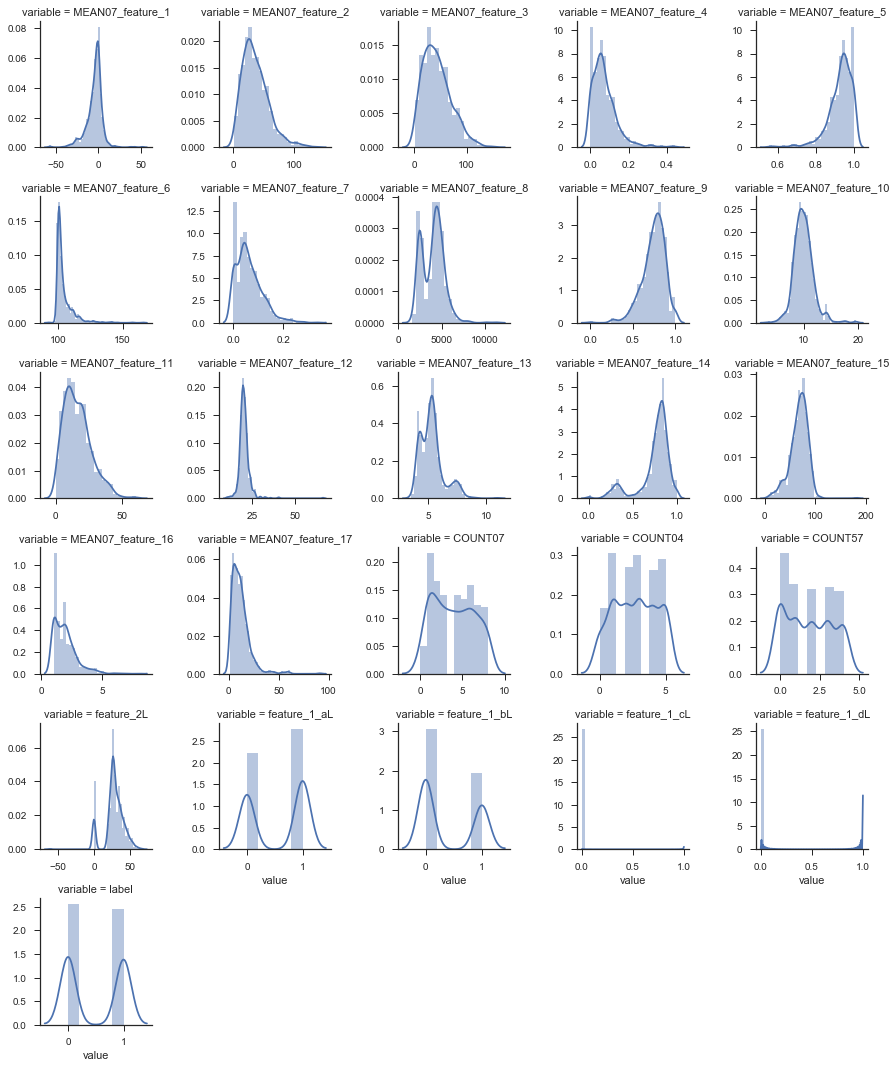

In [473]:
f = pd.melt(dfjoin, value_vars= meanfeats + ['COUNT07','COUNT04','COUNT57'] + lifefeats + ['label'])
g = sns.FacetGrid(f, col="variable", col_wrap=5, sharex=False, sharey=False, size=2.5 )
g = g.map(sns.distplot, "value")

The sample seems very unbalanced on the dummy variables coming from 'dflife'. Let's check the numbers:

a: 422 b: 294 c: 2 d: 41


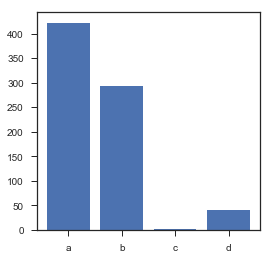

In [494]:
print('a:', len(dfjoin[dfjoin['feature_1_aL'] == 1]), 'b:',len(dfjoin[dfjoin['feature_1_bL'] == 1]),
     'c:', len(dfjoin[dfjoin['feature_1_cL'] == 1]), 'd:',len(dfjoin[dfjoin['feature_1_dL'] == 1]))
plt.figure(figsize = (4,4))
plt.bar(left=[1,2,3,4], height=[422,294,2,41], tick_label=['a','b','c','d'])
plt.show()

In [361]:
dfjoin[dfjoin['feature_1_cL'] == 1]['label']

courier
379136    1
478953    1
Name: label, dtype: int64

We realize that there is only two observations with feature_1 = c, and they are both labeled with a 1. It is a good idea then to eliminate the variable from the predictors. In addition we will also eliminate 'feature_1_aL' from the predictors to avoid collinearity.

Next step is to build a correlation matrix plot to identify the possible colinear variables and exclude them from the predictors. 

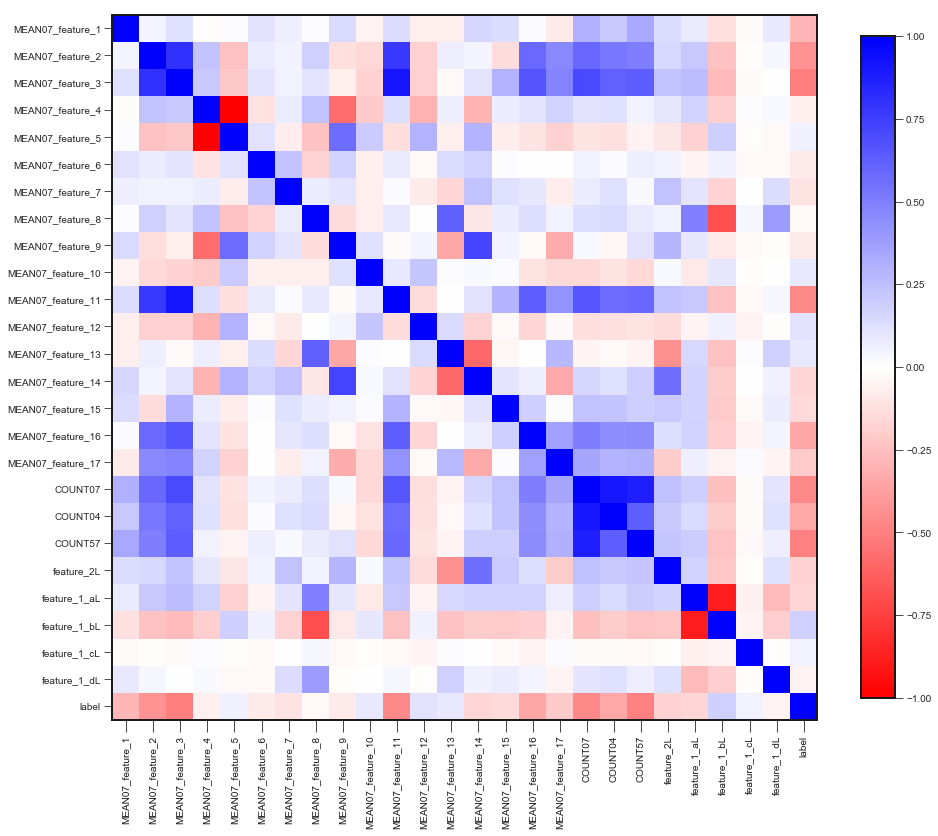

In [362]:
#correlation matrix
corr = dfjoin[meanfeats + ['COUNT07','COUNT04','COUNT57'] + lifefeats + ['label']].corr();
#Temporary aestetics for correlation matrix
temp_params = {'xtick.direction': 'out','xtick.major.size': 12,'xtick.minor.size': 8,'xtick.color': '0.1',
               'ytick.direction': 'out','ytick.major.size': 8,'ytick.minor.size': 8,'ytick.color': '0.15',
                'axes.linewidth': 2.0,'axes.edgecolor': '0.1','grid.color': '.9'}
sns.set_style("white", temp_params)
plt.figure(figsize = (14,14));
plt.imshow(corr, cmap=plt.cm.bwr_r, vmin = -1, vmax = 1)
tick_marks = list(range(len(corr.columns)))
plt.xticks(tick_marks, meanfeats + ['COUNT07','COUNT04','COUNT57'] + lifefeats + ['label'], rotation=90)
plt.yticks(tick_marks, meanfeats + ['COUNT07','COUNT04','COUNT57'] + lifefeats + ['label'])
plt.colorbar(shrink=0.7)
plt.tight_layout()
#Resetting aestetics
sns.set_style("white", params)

 There is a very strong correlation between 'MEAN07_feature_4' and 'MEAN07_feature_5'. We realize that indeed 'MEAN17_feature_4' = 1 - 'MEAN17_feature_5'. We need to eliminate one of them from the predictors.

1.0000010546084


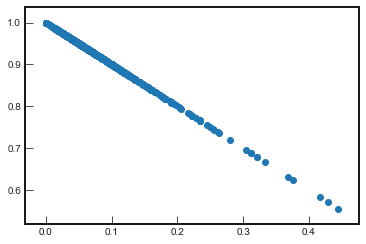

In [363]:
plt.scatter(dfjoin['MEAN07_feature_4'],dfjoin['MEAN07_feature_5'])
print(np.mean(dfjoin['MEAN07_feature_4']+dfjoin['MEAN07_feature_5']))

We check other suspicious variables, in this case there is no obvious collinearity.

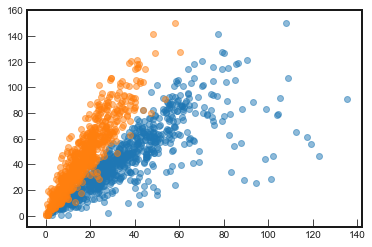

In [439]:
plt.scatter(dfjoin['MEAN07_feature_2'],dfjoin['MEAN07_feature_3'], alpha=0.5)
plt.scatter(dfjoin['MEAN07_feature_11'],dfjoin['MEAN07_feature_3'], alpha=0.5)

In the case of variables 'MEAN07_feature_13' and 'MEAN07_feature_14', there seems to be a clustering of the couriers. At first glance, it seems that it could offer some pretictive power on 'label'.

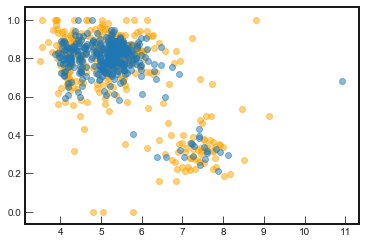

In [448]:
plt.scatter(dfjoin[dfjoin['label']==1]['MEAN07_feature_13'],
            dfjoin[dfjoin['label']==1]['MEAN07_feature_14'], alpha=0.5, color='orange')
plt.scatter(dfjoin[dfjoin['label']==0]['MEAN07_feature_13'],
            dfjoin[dfjoin['label']==0]['MEAN07_feature_14'], alpha=0.5)

We can also check the linear correlation of all predictiors with 'label', which gives a feeling of their potential predictive power. As one can see, only a few variables are fairly correlated with 'label'.

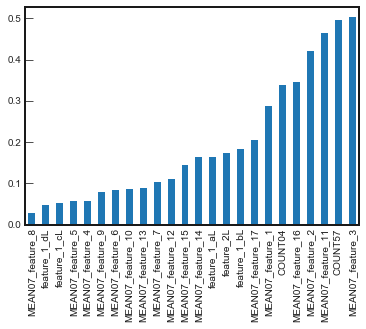

In [365]:
corrlabel = abs(dfjoin[meanfeats + ['COUNT04','COUNT57'] + lifefeats + ['label']].corr().loc[('label')])
corrlabel.sort_values().iloc[:-1].plot(kind='bar')

Finally we can make a dashboard that captures our findings using the pairplot from seaborn. In this case we will plot the most relevant variables, either for their behavior or their correlation with 'label'. The data is color coded according to 'label'.

In the pairplot one can appreciate:

 1) the correlation between the aggregated variables
 
 2) the clustering of the couriers in the variables 'MEAN07_feature_13' and 'MEAN07_feature_14'
 
 3) the correlation of the predictors with 'label' (see plots in the diagonal), specially for 'MEAN07_feature_3', 'MEAN07_feature_11' and 'COUNT57'
 
 4) the distribution of 'label' classes is highly overlaping for all the variables (bottom plots), which is an appropriate playground for a logistic regression. 

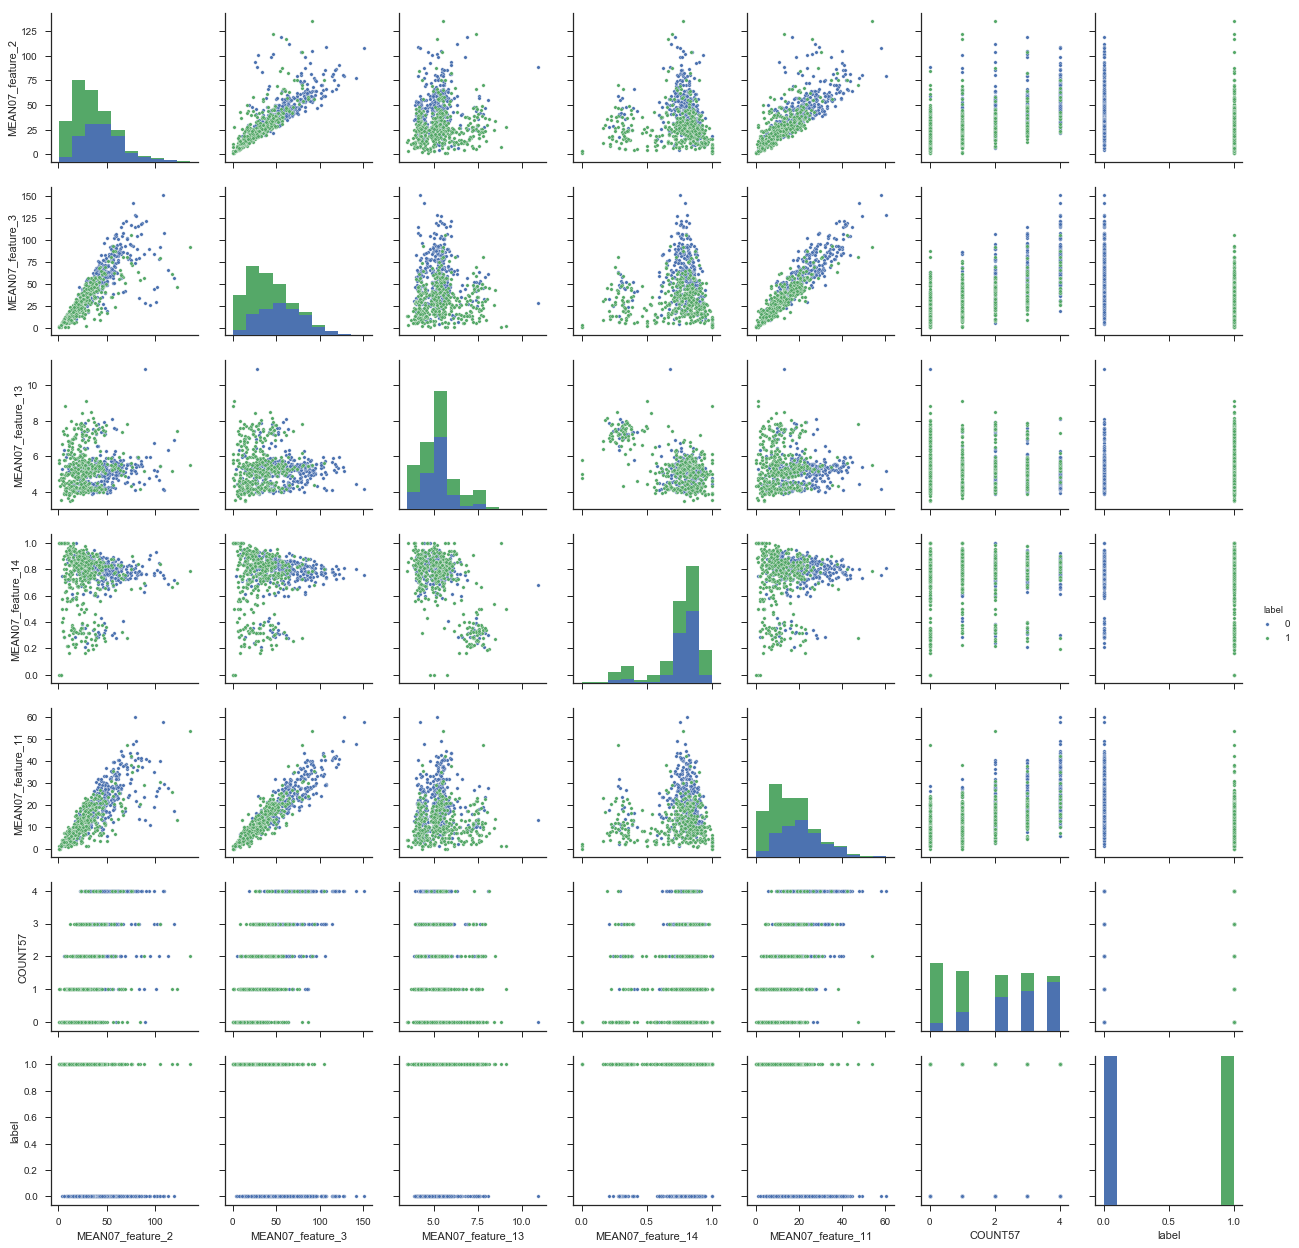

In [470]:
sns.set(style="ticks")
sns.pairplot(dfjoin[['MEAN07_feature_2','MEAN07_feature_3',
                     'MEAN07_feature_13','MEAN07_feature_14','MEAN07_feature_11','COUNT57',
                     'label']].dropna(), markers='.', hue='label')

## Task 2 and 3: Create a Predictive Algorithm and Evaluate it

### First model and evaluation with sklearn

We will start with the logistic regression provided by sklearn using the default parameters. This package includes some degree of regularization that we will tune later. For the predictors, we will use all the aggregated and lifetime variables (except the ones excluded to avoid collinearity), and the "count" ones. 

When we aggregated the variables, we solved the vast majority of the missing values problem. However there are a few couriers that only worked on weeks 8-11 and therefore the aggregated functions in weeks 1-7 return a NaN. To solve this issue we can either drop them or fill them with mean values (we can check which option gives the best results when we crossvalidate the results).

In [413]:
# Proportion of missing values
len(dfjoin[meanfeats + ['COUNT04',
'COUNT57','label'] + lifefeats].dropna())/ len(dfjoin[meanfeats + ['COUNT04','COUNT57','label'] + lifefeats])

0.9604743083003953

In [414]:
# We create a new df with only the agreggated and lifetime varibles, and filling the NaNs
dfjoin2 = dfjoin[meanfeats + ['COUNT04','COUNT57','label'] + lifefeats].dropna()

In [415]:
# We will start spliting the sample in train and test sets
features_to_include = ['MEAN07_feature_1','MEAN07_feature_2','MEAN07_feature_3','MEAN07_feature_4',
 'MEAN07_feature_6','MEAN07_feature_7','MEAN07_feature_8','MEAN07_feature_9','MEAN07_feature_10',
 'MEAN07_feature_11','MEAN07_feature_12','MEAN07_feature_13','MEAN07_feature_14','MEAN07_feature_15',
 'MEAN07_feature_16','MEAN07_feature_17','COUNT04','COUNT57','feature_2L','feature_1_bL','feature_1_dL']
X_train, X_test, y_train, y_test = train_test_split(dfjoin2[features_to_include], dfjoin2['label'], test_size=0.2)

In [416]:
# We will use the regressor provided by sklearn. We train in on the train set, and use it to predict the test set
clf = LogisticRegression()
clf.fit(X_train, y_train)
predictions = clf.predict(np.array(X_test))
y_score = clf.predict_proba(np.array(X_test))[:,1]

There are several ways to evaluate the performance of a classifier, ranging from very simple to more nuanced:

1) Accuracy: rate of true positives over total positives.

2) Confusion matrix: count of true positives and true negatives (in the diagonal), and false positives and false negatives (off diagonal). With these counts we can compute other metrics like the precision, the recall, the accuracy or true negative rate.

3) ROC curve: True and false positives depending on the threshold used for classification. One might also compute the area under the curve as a numeric metric for the model, which is usually used as a score to tune the hyper-parameters. Since we don't know what threshold would be appropriate for the company's goals, the area under ROC seems a good evaluation metric for this exercise.

In [417]:
# With the predictions we can now check the score provided by the package
# this measures the accuracy (true positives)
clf.score(X_test, y_test, sample_weight=None)

0.77397260273972601

In [418]:
# Example of confusion matrix on test set
confusion_matrix(y_test, predictions)

array([[57, 14],
       [19, 56]])

Area under curve (ROC): 0.838309859155


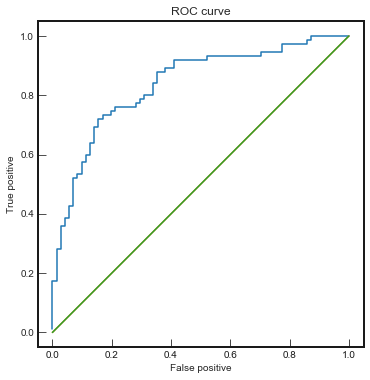

In [419]:
# ROC curve and computation of area under curve
plt.figure(figsize = (6,6));
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_score)
plt.plot(fpr_rt_lm, tpr_rt_lm, label='ROC logistic regression')
plt.plot([[0,0],[1,1]])
plt.title('ROC curve')
plt.xlabel('False positive')
plt.ylabel('True positive')
plt.axes().set_aspect('equal')
print('Area under curve (ROC):',roc_auc_score(y_test, y_score))

### Cross validation with k-folds and grid search

An effective way to shrink the model is to use regularization (L1 or L2 norm, like in LASSO or in ridge regression). The sklearn library that implements the logistic regression includes the option for regularization, being the hyperparameter 'C' the strength of it.

We will use 'LogisticRegressionCV' to compute the k-fold cross-validated score of the model (auc_roc), and tune the hyperparameter 'C' from the logistic regression. This library uses an exhaustive grid search (try all possibilities, picks the best). Since the model fitting is very quick and there is only one hyperparameter to tune, it is a good idea to use the grid search. A randomized search is potentially faster, although in this case is not necessary.

We manually tuned the 'solver' (and the type of regularization) and obtained the best results for 'liblinear' with L1 regularization (with a very small difference).

In [387]:
# Fold object for the cross-validation
fold = KFold(len(dfjoin2), n_folds=5, shuffle=True, random_state=777)
#searchCV = LogisticRegressionCV( Cs=list(np.power(10.0, np.arange(-10, 10))),penalty='l2',
#                               scoring='roc_auc',cv=fold, random_state=777 ,max_iter=100000, 
#                               fit_intercept=True,solver='newton-cg', tol=10)
searchCV = LogisticRegressionCV(penalty='l1' ,solver='liblinear',Cs=list(np.power(10.0, np.arange(-10, 10))),
                                refit=True,scoring='roc_auc')
searchCV.fit(dfjoin2[features_to_include], dfjoin2['label'])
print ('Max auc_roc:', searchCV.scores_[1].mean(axis=0).max())

Max auc_roc: 0.841932910518


Alternatively, we can grid search with 'GridSearchCV' with very similar results. In this case we can extract the value that maximizes the score.

In [388]:
grid = {'C': np.power(10.0, np.arange(-10, 10)), 'solver': ['liblinear']}
clf = LogisticRegression(penalty='l1', max_iter=10000)
gs = GridSearchCV(clf, grid, scoring='roc_auc', cv=fold)
gs.fit(dfjoin2[features_to_include], dfjoin2['label'])

print ('Max auc_roc:', gs.best_score_, ', with parameter C =', gs.best_params_['C'] )

Max auc_roc: 0.840165260707 , with parameter C = 0.1


Additionally, since we are using L1, one can check that indeed many of the coefficients have shrank to 0, and which are the ones that have survived.

In [436]:
clf = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
clf.fit(np.array(X_train), np.array(y_train))
print(clf.coef_[0])
print(np.array(features_to_include)[clf.coef_[0]!=0])

[ -5.07228783e-02   2.38513839e-03  -4.15641077e-02   0.00000000e+00
   1.35685376e-02   0.00000000e+00   8.19208194e-05   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.48406884e-03   0.00000000e+00
   0.00000000e+00   9.27444263e-03   0.00000000e+00   5.05833674e-03
   0.00000000e+00  -4.88854845e-01  -8.36651138e-03   0.00000000e+00
   0.00000000e+00]
['MEAN07_feature_1' 'MEAN07_feature_2' 'MEAN07_feature_3'
 'MEAN07_feature_6' 'MEAN07_feature_8' 'MEAN07_feature_12'
 'MEAN07_feature_15' 'MEAN07_feature_17' 'COUNT57' 'feature_2L']


### Comparison with random forest, does interaction add much?

In [421]:
clf = LogisticRegression(C=0.1, max_iter=100000, penalty='l1', solver='liblinear' )
clf.fit(np.array(X_train), np.array(y_train))
predictions = clf.predict(np.array(X_test))
y_score = clf.predict_proba(np.array(X_test))[:,1]

crf = RandomForestClassifier(max_features=5, n_estimators=1500)
crf.fit(np.array(X_train), np.array(y_train))
predictionsf = crf.predict(np.array(X_test))
y_scoref = crf.predict_proba(np.array(X_test))[:,1]

Area under curve (ROC) Logistic regression: 0.838685446009
Area under curve (ROC) Random forest: 0.836056338028


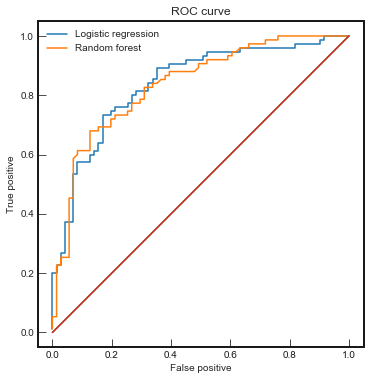

In [422]:
plt.figure(figsize = (6,6));
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_score)
fpr_rt_lmf, tpr_rt_lmf, _ = roc_curve(y_test, y_scoref)
plt.plot(fpr_rt_lm, tpr_rt_lm, label='Logistic regression')
plt.plot(fpr_rt_lmf, tpr_rt_lmf, label='Random forest')
plt.plot([[0,0],[1,1]])
plt.title('ROC curve')
plt.xlabel('False positive')
plt.ylabel('True positive')
plt.legend(loc='best')
plt.axes().set_aspect('equal')
print('Area under curve (ROC) Logistic regression:',roc_auc_score(y_test, y_score))
print('Area under curve (ROC) Random forest:',roc_auc_score(y_test, y_scoref))

The models perform very similarly, suggesting that the interaccions do not play a major role in the outcome.

### Summary of the predictive model

1) Logistic regression with sklearn.LogisticRegression

2) Optimisation of hyperparameters with grid search: fast fit and only one parameter. We optimize the regularization penalty strength C to 0.1.

3) Evaluation metric: area under the ROC curve. This metric is more nuanced than the precision, as it takes into account the estimated probability of the positives. Since we don't know what threshold would be appropriate for the company's goals, the area under ROC seems a good evaluation metric. Result obtained with cross validation: 
Max auc_roc = 0.841932910518

Later on, with more data, more feature engineering and different algorithm(xgboost), it is improved 0.94 auc_roc. However, I am not allowed to share that part of the code due to NDA.